<a href="https://colab.research.google.com/github/marcelogarret/reconpad/blob/main/aula7a_arvore_atributos_continuos_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target

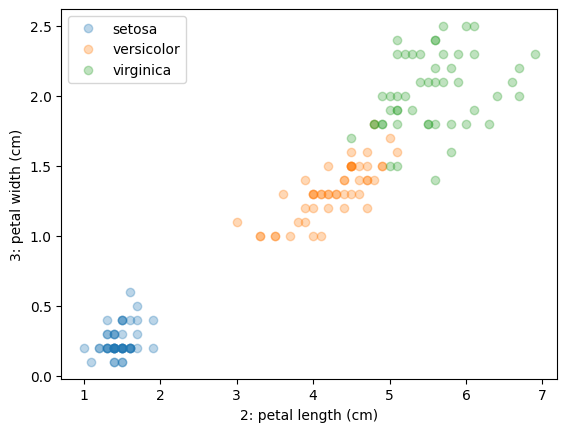

In [2]:
import matplotlib.pyplot as plt
i, j = 2,3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")
for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], "o", alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [3]:
import random
import numpy as np

def sorteiaCaracteristica(X, y):
  caracteristica = random.randint(a=0, b=X.shape[1]-1)
  valor = random.uniform(a=np.min(X[:,caracteristica]), b=np.max(X[:,caracteristica]))
  return caracteristica, valor
sorteiaCaracteristica(X, y)

(1, 3.9655311484838065)

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor = sorteiaCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self

  def predict(self, X):
    y = np.empty((X.shape[0]), dtype=int) ## Correção: Foi adicionado o "dtype=int" pois o método predict deveria retornar um array de inteiros, mas por padrão a função np.empty cria um array de floats.
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

results = cross_validate(Arvore(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.93333333, 0.86666667, 0.96666667, 0.93333333]),
 0.9333333333333333)

In [5]:
from sklearn.ensemble import BaggingClassifier
modelo = BaggingClassifier(Arvore(),
                           n_estimators=100)
results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

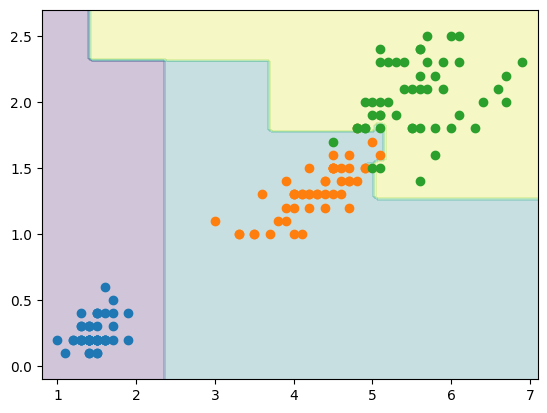

In [6]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{dataset.target_names[k]} [{k}]")
    plt.show()

plotDecisao(Arvore(), X[:,2:], y)